# Homework 6 – Explain the Titanic disaster
The titanic dataset is one of the most common introductory problems for data science. For this weeks homework we want you to complete the following tasks:

- Load the dataset in the format provided by the seaborn library `sns.load_dataset('titanic')`
- Clean the dataset and fix any issues you encounter (e.g., duplicated columns, missing values, ...)
- Train a catboost model to predict which passengers will survive. Please report the accuracy of your model.
- Use explanation techniques (e.g., SHAP) to discuss who did or did not survive the titanic disaster. Provide at least three visualizations (i.e., explanations) and write down the conclusions you draw from each visualization.

**Please make sure:**

- Each cell (essential step) is commented on with a short sentence
- New variables / fields are output in sufficient length (e.g., df.head(10))
- Each of the tasks is answered with a short written statement
- Tidy up your code
- Coding Area

In [66]:
# General data science packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import *
import numpy as np

from imblearn.over_sampling import SMOTE
from yellowbrick.classifier.rocauc import roc_auc
# wraps third party clfs
from yellowbrick.contrib.wrapper import classifier

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (
    accuracy_score,
    classification_report
)

import optuna

# SHAP package
import shap
shap.initjs() # Initializes the JS Library

In [67]:
titanic_dataset = sns.load_dataset('titanic')

In [68]:
titanic_dataset_type = type(titanic_dataset)
titanic_dataset_elements = titanic_dataset.keys()
print("Type:", titanic_dataset_type)
print("Dictionary Elements:", titanic_dataset_elements)

Type: <class 'pandas.core.frame.DataFrame'>
Dictionary Elements: Index(['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare',
       'embarked', 'class', 'who', 'adult_male', 'deck', 'embark_town',
       'alive', 'alone'],
      dtype='object')


In [69]:
titanic_dataset.head(10)

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
5,0,3,male,NaN,0,0,8.4583,Q,Third,man,True,NaN,Queenstown,no,True
6,0,1,male,54.0,0,0,51.8625,S,First,man,True,E,Southampton,no,True
7,0,3,male,2.0,3,1,21.0750,S,Third,child,False,NaN,Southampton,no,False
8,1,3,female,27.0,0,2,11.1333,S,Third,woman,False,NaN,Southampton,yes,False
9,1,2,female,14.0,1,0,30.0708,C,Second,child,False,NaN,Cherbourg,yes,False


In [70]:
titanic_dataset.describe()

,survived,pclass,age,sibsp,parch,fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [71]:
titanic_dataset.isna().sum()

survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64

In [72]:
# find "untrue" nans e. g. in deck
titanic_dataset.replace('NaN', np.NaN, inplace=True)
titanic_dataset.isna().sum()

survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64

In [73]:
# see here: https://en.wikipedia.org/wiki/Passengers_of_the_Titanic
titanic_dataset.fillna({'class':'Third'}, inplace=True)

In [74]:
titanic_dataset.age = titanic_dataset.age.fillna(titanic_dataset.age.median())

In [75]:
# fill embarked with most frequent val
titanic_dataset.embarked = titanic_dataset.embarked.fillna(titanic_dataset.age.median())
titanic_dataset.embark_town = titanic_dataset.embark_town.fillna(titanic_dataset.age.median())

In [76]:
titanic_dataset.isna().sum()

survived         0
pclass           0
sex              0
age              0
sibsp            0
parch            0
fare             0
embarked         0
class            0
who              0
adult_male       0
deck           688
embark_town      0
alive            0
alone            0
dtype: int64

In [77]:
print(titanic_dataset.dtypes)

survived          int64
pclass            int64
sex              object
age             float64
sibsp             int64
parch             int64
fare            float64
embarked         object
class          category
who              object
adult_male         bool
deck           category
embark_town      object
alive            object
alone              bool
dtype: object


In [78]:
# encode classes, who, sex, embark_town
object = titanic_dataset.select_dtypes(include=['object']).columns

# convert to category type first and extract codes e. g. F-> 0, M -> 1 etc.
titanic_dataset[object] = titanic_dataset[object].apply(lambda x: x.astype('category'))

categorical = titanic_dataset.select_dtypes(include=['category']).columns
titanic_dataset[categorical] = titanic_dataset[categorical].apply(lambda x: x.cat.codes)

titanic_dataset.head(10)


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,1,22.0,1,0,7.2500,3,2,1,True,-1,3,0,False
1,1,1,0,38.0,1,0,71.2833,1,0,2,False,2,1,1,False
2,1,3,0,26.0,0,0,7.9250,3,2,2,False,-1,3,1,True
3,1,1,0,35.0,1,0,53.1000,3,0,2,False,2,3,1,False
4,0,3,1,35.0,0,0,8.0500,3,2,1,True,-1,3,0,True
5,0,3,1,28.0,0,0,8.4583,2,2,1,True,-1,2,0,True
6,0,1,1,54.0,0,0,51.8625,3,0,1,True,4,3,0,True
7,0,3,1,2.0,3,1,21.0750,3,2,0,False,-1,3,0,False
8,1,3,0,27.0,0,2,11.1333,3,2,2,False,-1,3,1,False
9,1,2,0,14.0,1,0,30.0708,1,1,0,False,-1,1,1,False


In [79]:
# remove look ahead bias
titanic_dataset.drop(columns={'alive'}, inplace=True)

<AxesSubplot:>

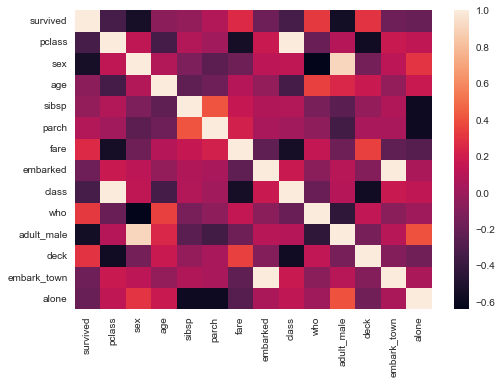

In [80]:
corr = titanic_dataset.corr()
sns.heatmap(corr, xticklabels=corr.columns.values,yticklabels=corr.columns.values)

In [81]:
# remove columns with high correlation
titanic_dataset.drop(columns={'adult_male', 'class', 'embarked'}, inplace=True)
# remove "who" as it is redundandent in a sense that everythin is encode in "sex" and "age"
titanic_dataset.drop(columns={'who'}, inplace=True)
# remove deck due to large number of missing vals
titanic_dataset.drop(columns={'deck'}, inplace=True)

In [82]:
titanic_dataset.isna().sum()

survived       0
pclass         0
sex            0
age            0
sibsp          0
parch          0
fare           0
embark_town    0
alone          0
dtype: int64

The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.


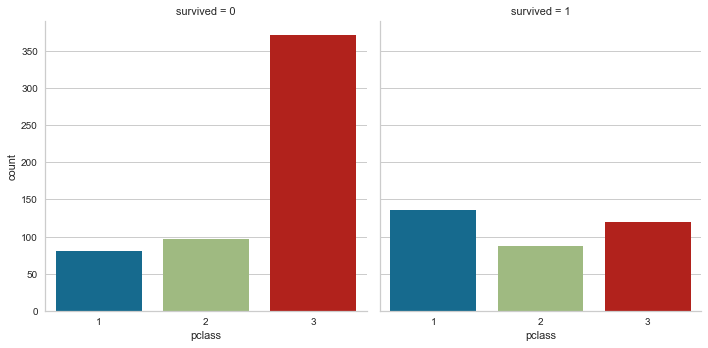

In [83]:
# compare survivors by pclass
sns.factorplot(x='pclass', col = 'survived', data = titanic_dataset, kind = 'count')

The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.


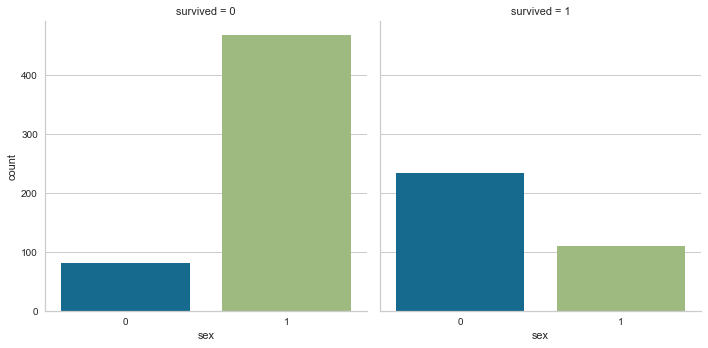

In [84]:
# compare survivors by sex
sns.factorplot(x='sex', col = 'survived', data = titanic_dataset, kind = 'count')

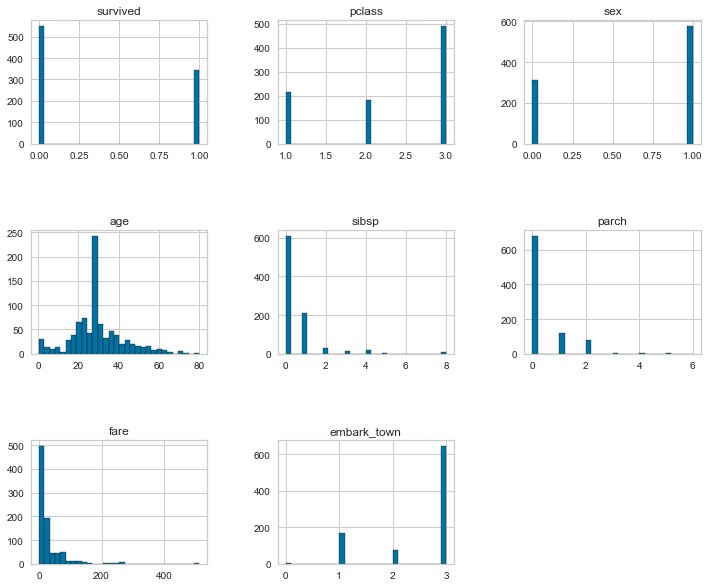

In [85]:
titanic_dataset.hist(figsize=(12, 10), bins=30, edgecolor="black")
plt.subplots_adjust(hspace=0.7, wspace=0.4)

**Short statement:** We encoded all categorical features as numerical values, removed highly correlating columns and filled missing data with the "known" most frequent value or the most frequent value in the data set.

In [86]:
# do train test split
X = titanic_dataset.iloc[:,1:]
y = titanic_dataset['survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [87]:
# resample
smote = SMOTE(random_state=42, sampling_strategy='auto')
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

In [88]:
def objective_cat(trial):
    """
    The following class has been adapted from here:
    https://github.com/optuna/optuna-examples/blob/main/sklearn/sklearn_additional_args.py
    It is used to pass custom argument sto the objective function
    """

    iterations = trial.suggest_int("iterations", 800, 1200, log=False)
    learning_rate = trial.suggest_float("learning_rate", 3e-4, 0.5e0, log=True)
    depth = trial.suggest_int("depth", 2, 8, log=False)

    params = {'iterations' : iterations, 'learning_rate':learning_rate, 'depth':depth, 'od_type': 'Iter', 
    'logging_level':'Silent', 'task_type':"GPU", "eval_metric":"Accuracy"
    }

    model = CatBoostClassifier(**params)

    # Handle pruning based on the intermediate value.
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()

    score = cross_val_score(model, X_train_balanced, y_train_balanced, cv=3, scoring='accuracy')        
    metric = score.mean()  
    return metric

In [89]:
study = optuna.create_study(direction='maximize') 
study.optimize(objective_cat, n_trials=2)

# print best params
optimized_params= study.best_trial.params
print(optimized_params)

[I 2021-12-18 14:12:32,619] A new study created in memory with name: no-name-8c9e1b4d-76bf-4026-97de-1635918ec93b
Custom logger is already specified. Specify more than one logger at same time is not thread safe.[I 2021-12-18 14:18:11,202] Trial 0 finished with value: 0.8342757697456493 and parameters: {'iterations': 819, 'learning_rate': 0.015444377918860754, 'depth': 3}. Best is trial 0 with value: 0.8342757697456493.
[I 2021-12-18 14:24:38,135] Trial 1 finished with value: 0.8276091030789826 and parameters: {'iterations': 976, 'learning_rate': 0.11683148845473579, 'depth': 7}. Best is trial 0 with value: 0.8342757697456493.


{'iterations': 819, 'learning_rate': 0.015444377918860754, 'depth': 3}


In [90]:
best_clf_cat = CatBoostClassifier(**optimized_params).fit(X_train_balanced, y_train_balanced, plot=True, eval_set=(X_test, y_test))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6818688	test: 0.6827633	best: 0.6827633 (0)	total: 5.35ms	remaining: 4.38s
1:	learn: 0.6719092	test: 0.6737813	best: 0.6737813 (1)	total: 10.1ms	remaining: 4.11s
2:	learn: 0.6656350	test: 0.6672843	best: 0.6672843 (2)	total: 14.1ms	remaining: 3.83s
3:	learn: 0.6563516	test: 0.6589347	best: 0.6589347 (3)	total: 18.3ms	remaining: 3.72s
4:	learn: 0.6480438	test: 0.6510101	best: 0.6510101 (4)	total: 30.8ms	remaining: 5.01s
5:	learn: 0.6392429	test: 0.6430400	best: 0.6430400 (5)	total: 35ms	remaining: 4.74s
6:	learn: 0.6309009	test: 0.6357496	best: 0.6357496 (6)	total: 39.2ms	remaining: 4.55s
7:	learn: 0.6246533	test: 0.6300964	best: 0.6300964 (7)	total: 42.7ms	remaining: 4.33s
8:	learn: 0.6184903	test: 0.6240551	best: 0.6240551 (8)	total: 46.4ms	remaining: 4.17s
9:	learn: 0.6107657	test: 0.6171124	best: 0.6171124 (9)	total: 50.5ms	remaining: 4.09s
10:	learn: 0.6049063	test: 0.6114736	best: 0.6114736 (10)	total: 53.6ms	remaining: 3.94s
11:	learn: 0.5993706	test: 0.6059021	best: 

In [91]:
y_pred_model = best_clf_cat.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred_model):.2f}")

Accuracy: 0.83


In [92]:
print(classification_report(y_test, y_pred_model))

              precision    recall  f1-score   support

           0       0.83      0.90      0.87       175
           1       0.84      0.73      0.78       120

    accuracy                           0.83       295
   macro avg       0.83      0.82      0.82       295
weighted avg       0.83      0.83      0.83       295



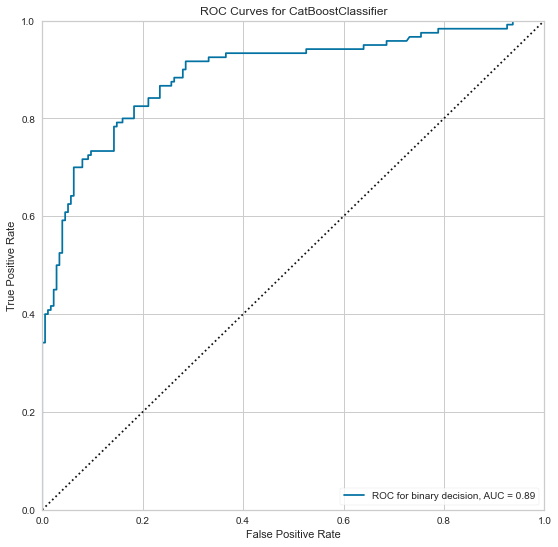

In [93]:
# print roc curve
plt.figure(figsize=(9, 9))
roc_auc(classifier(best_clf_cat), X_train_balanced, y_train_balanced, X_test=X_test, y_test=y_test, classes=['False', 'True'], binary=True)
plt.show()

**Short statement**
We performed a train-test-split, resampled imbalanced classes and trained a CatBoost model using a Bayesian search. Results could have been improved with more trials. Accuracy is ok with > 80, but we have to be aware that classes are also imbalanced.

## Visualization 1, 2 and 3

In [94]:
# Refit on entire dataset

shap_values = best_clf_cat.get_feature_importance(Pool(X_test,label=y_test),type="ShapValues")

expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]

# Explain the model's predictions using SHAP's Explainer module
explainer = shap.Explainer(best_clf_cat)

# Calculate the SHAP values for all instances X
shap_values_explainer = explainer(X_test)

In [95]:
# Visualize the first prediction's explanation with a force plot:
shap.force_plot(shap_values_explainer[0])

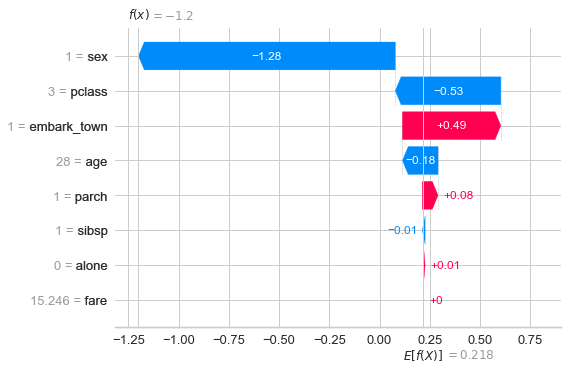

In [96]:
shap.plots.waterfall(shap_values_explainer[0])

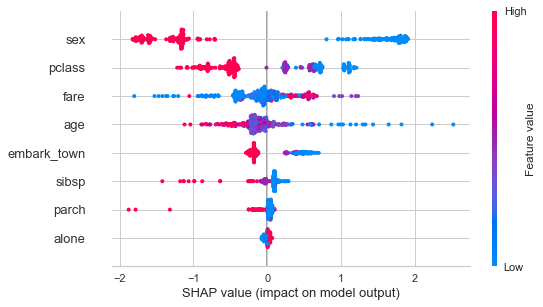

In [97]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values_explainer)

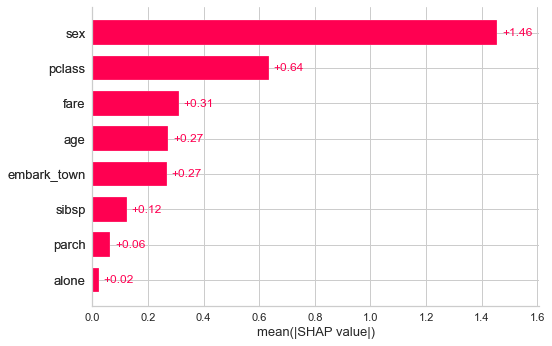

In [98]:
shap.plots.bar(shap_values_explainer)

**Conclusion:**
- Sex plays an important role, whether a passenger survived or not. (See bar plot) If you were female, you were much more likely to survive. (See beeplot)
- Passenger class tells us that if you boarded a lower class like second class or third class, then you had a much smaller chance of survival. 
- Also, embark town, fare and age are important. (See bar plot) Regarding the age: the younger you were, the more likely you were to survive. For people who paid more for their fares, had a higher chance of survival. This goes hand-in-hand with the passenger class observation. (see bee plot)
- While sex and passenger class helped to push the prediction lower. That is a lower rate of survival, the embark town pushes the survival rate to the opposite.

<hr/>

## Coding Area

In [99]:
# empty